In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout, Flatten,Bidirectional
from keras_self_attention import SeqSelfAttention
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
import music21
import time
from music21 import converter, instrument, note, chord, stream
# import midi

maxv = 104
minv = 22
epochs= 500
PATH = '/content/drive/MyDrive/Velocity/'
modelname = time.strftime('%Y-%m-%d', time.localtime(time.time()))+f"-weights.kbmode3-7_epoch{epochs}_sparse2.hdf5"

In [4]:
def make_Data():
    ''' 
    Load dataset
    '''
    with open(PATH+"Data3.pickle",'rb') as file : 
      notes = pickle.load(file)
    return notes

In [5]:
def prepare_sequences(notes):
    '''
    Create input data and output data
    '''
    network_input = []
    network_output = []
    maxv =  max([_[0] for _ in notes])
    minv = min([_[0] for _ in notes])

    for i in notes:
        network_input.append(i[:-1])
        network_output.append(i[-1])
        # data normalization
        network_input[-1][0] = (network_input[-1][0]-minv) / (maxv-minv)
    n_patterns = len(network_input)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    network_output = np.array(network_output)
    return (network_input, network_output)


In [6]:
def create_network(network_in):
    """Create the model architecture"""

    learning_rate = 0.005

    model = Sequential()
    model.add(LSTM(512, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    model.add(Dropout(0.2))
    model.add(LSTM(256, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    model.add(LSTM(128, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Activation('softmax'))

    # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss,loss_weights=0.05,optimizer="adam")

    model.summary()
    return model

In [7]:
def train(model, network_input, network_output, epochs):
    """
    Train the neural network
    """
    filepath = PATH+modelname
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    return model.fit(network_input, network_output, epochs=epochs, batch_size=128, callbacks=[checkpoint],shuffle=True)


In [8]:
notes = make_Data()
network_in, network_out = prepare_sequences(notes)
model = create_network(network_in)
history = train(model, network_in, network_out, epochs)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 512)            1052672   
                                                                 
 seq_self_attention (SeqSelf  (None, 3, 512)           32833     
 Attention)                                                      
                                                                 
 dropout (Dropout)           (None, 3, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            787456    
                                                                 
 seq_self_attention_1 (SeqSe  (None, 3, 256)           16449     
 lfAttention)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 3, 128)            1

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


85/85 [==============================] - 20s 12ms/step - loss: 0.2193
Epoch 2/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2142
Epoch 3/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2140
Epoch 4/500
85/85 [==============================] - 1s 13ms/step - loss: 0.2137
Epoch 5/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2135
Epoch 6/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2134
Epoch 7/500
85/85 [==============================] - 1s 11ms/step - loss: 0.2134
Epoch 8/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2133
Epoch 9/500
85/85 [==============================] - 1s 12ms/step - loss: 0.2133
Epoch 10/500
85/85 [==============================] - 1s 15ms/step - loss: 0.2133
Epoch 11/500
85/85 [==============================] - 1s 16ms/step - loss: 0.2132
Epoch 12/500
85/85 [==============================] - 1s 16ms/step - loss: 0.2130
Epoch 13/500
85/85 [================

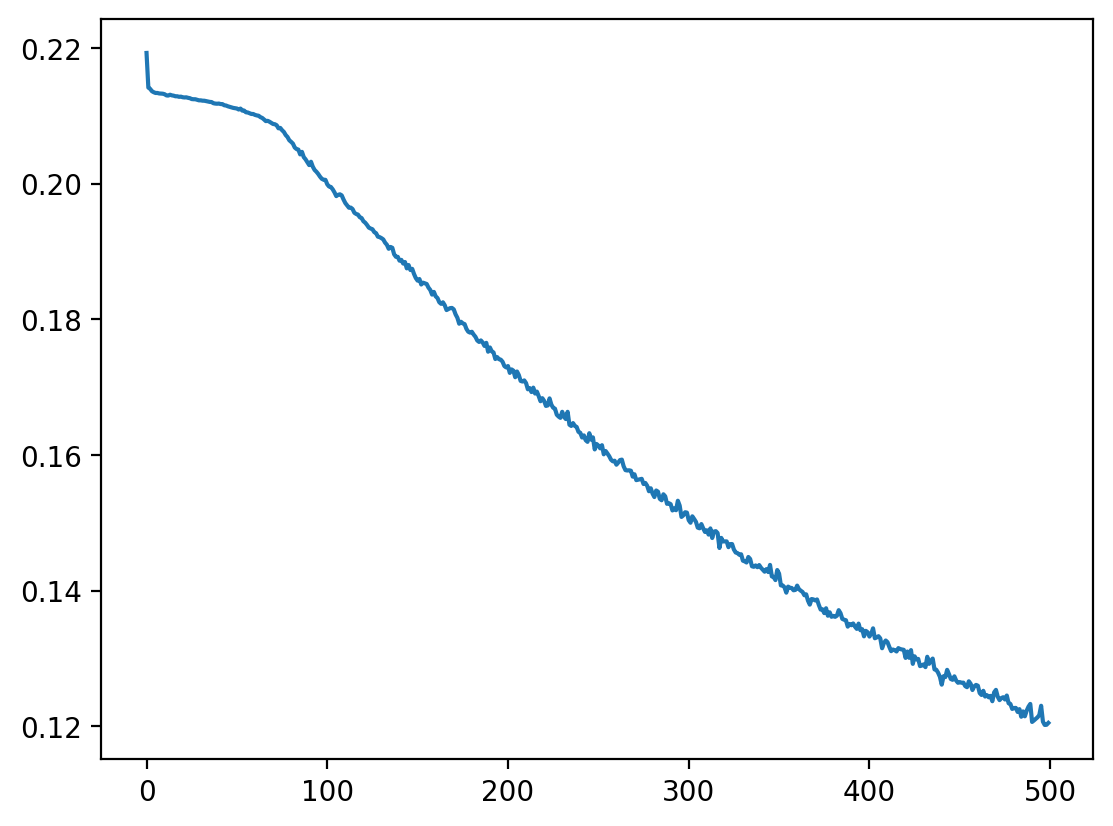

In [9]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [10]:
def generate(name):
    """ Velocity Prediction """

    # Get data to predict
    with open(PATH + name+'.pickle', 'rb') as filepath:
        notes = pickle.load(filepath)

    print('Initiating music generation process.......')

    # Creating data input
    n_patterns = len(notes)
    network_input = []
    for idx,_ in enumerate(notes) :
        network_input.append(_[:])
        network_input[-1][0] = (network_input[-1][0] - minv) / (maxv - minv)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    model = create_network(network_input)
    print('Loading Model weights.....')
    model.load_weights(PATH+modelname)
    print('Model Loaded')

    # Velocity Prediction
    prediction_output = generate_notes(model, network_input)
    create_midi(i,notes,prediction_output)

In [11]:

def generate_notes(model, network_input):
    """ Velocity Prediction with Pitch, Offset and Duration """
    prediction_output = []

    #  0-127 Velocity Prediction
    for note_index in range(network_input.shape[0]):
        prediction_input = np.reshape(network_input[note_index], (1, len(network_input[note_index]), 1))
        prediction = model.predict(prediction_input, verbose=0)
        prediction_output.append(int(np.where(prediction==np.max(prediction))[1]))

    return prediction_output

In [12]:
def create_midi(name,network_input,prediction_output):
    """ Put the predicted velocity value into the actual MIDI and save it. """
    offset = 0
    output_notes = []

    for idx,pattern in enumerate(network_input):
        new_note = note.Note(pattern[0])
        new_note.volume.velocity =  prediction_output[idx]
        new_note.offset = pattern[1]
        new_note.quarterLength=pattern[2]
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    midi_stream = stream.Stream(output_notes)

    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='/content/drive/MyDrive/output/'+name+'.mid')

In [13]:
midi_names = ['80-46-1', '81-67-1', '81-67-2', '82-31-1', '83-18-1', '84-35-1', '84-35-2', '85-55-1', '86-30-1', '87-38-1', '88-36-1', '88-36-2', '89-35-1', '90-43-1']
for i in midi_names : 
  generate(i)

Initiating music generation process.......
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 512)            1052672   
                                                                 
 seq_self_attention_3 (SeqSe  (None, 3, 512)           32833     
 lfAttention)                                                    
                                                                 
 dropout_2 (Dropout)         (None, 3, 512)            0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 256)            787456    
                                                                 
 seq_self_attention_4 (SeqSe  (None, 3, 256)           16449     
 lfAttention)                                                    
                                                                 
 lstm_5 (LS